# Preparation

## Resources

In [101]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedGroupKFold

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
fold_chosen = 2
classify = "mat"
brand = "gucci"
location = 1
model_path = f"./mat/model/MatK{fold_chosen}_1.0.h5"
label_path = f"./mat/MatLB{fold_chosen}"
train_dir = '/storage/intern/train'
val_dir = "/storage/intern/val"
meta_path = "/storage/experiments/matpatclassify/csv/"
batch_size = 32

In [80]:
# Function for import data
def data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen, split=5):
    path_bag_loc_df = pd.read_csv(meta_path + 'imagepaths.csv')
    path_bag_df = path_bag_loc_df[path_bag_loc_df.location == location].drop("location", axis=1)
    bag_classify_df = pd.read_csv(meta_path + f'bags{brand}.csv')[['bag', classify]]
    path_bag_classify_df = path_bag_df.merge(bag_classify_df, how='left', on='bag').replace(r'^\s*$', np.NaN, regex=True).dropna(axis=0)
    # Stratified Group K-fold
    path_bag_classify_df['fold'] = -1
    sgkf = StratifiedGroupKFold(n_splits=split)
    for fold, (train_idxs, test_idxs) in enumerate(sgkf.split(X=path_bag_classify_df['path'].values, 
                                                              y=path_bag_classify_df[classify].values, 
                                                              groups=path_bag_classify_df['bag'])):
        path_bag_classify_df.iloc[test_idxs, 3] = fold
    path_classify_df = path_bag_classify_df.drop("bag", axis= 1)
    train_df = path_classify_df[path_classify_df.fold != fold_chosen].drop("fold", axis=1)
    val_df = path_classify_df[path_classify_df.fold == fold_chosen].drop("fold", axis=1)
    labels = np.intersect1d(train_df[classify].unique(), val_df[classify].unique())
    train_df2 = train_df[train_df[classify].isin(labels)]
    val_df2 = val_df[val_df[classify].isin(labels)]
    print(f"Take {fold_chosen}th fold for validation")
    print(f"Train: {len(train_df)} samples, {len(train_df[classify].unique())} classes.")
    print(f"Validation: {len(val_df)} samples, {len(val_df[classify].unique())} classes.")
    print(f"Use intersecting label with {len(labels)} classes.")
    print(f"Using {round(train_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in train dataset.")
    print(f"Using {round(val_df[classify].isin(labels).value_counts(normalize=True)[1], 4) * 100}% samples in validation dataset.")
    return train_df2, val_df2, labels

In [79]:
# Function for lower triangle confusion matrix
def tril_confusion_matrix(y_true, y_pred, normalize = None, tril=True):
    """Create a lower triangle confusion matrix

    Args:
        y_true (NumpyArray): true labels
        y_pred (NumpyArray): prediction labels
        normalize ("true", "pred", "all", None optional): Choose whether normalize or not. Defaults to None.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    # Create an mask for triangle
    mask = np.ones_like(cm, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()

    if tril == True:
        sns.heatmap(cm, ax=ax, mask=mask, cmap="Blues", square=True, linewidths=.5)
    else:
        sns.heatmap(cm, ax=ax, cmap="Blues", square=True, linewidths=.5)

    ax.set_xlabel('Predicted Label', fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    plt.title('Lower Triangle Confusion Matrix', fontsize=20)
    # plt.savefig('ConfusionMat.png')
    plt.show()

In [88]:
# Function for find the worst error
def find_the_worst_error(prob, y_pred, y_true, label_names, data_ds, batch_size):
    """Input numpy array with probability, prediction labels, true labels, dataset, batch size.
    Which return the worst prediction picture, predict and label

    Args:
        prob (ndarray): probability after prediction
        y_pred (numpy.parray): prediction label of dataset
        y_true (numpy.array): true label of dataset
        data_ds (tf.dataset): dataset
        batch_size (int): batch size of dataset
        label_names (list): list of labels class name

    Returns:
        _type_: _description_
    """
    
    # Find index
    mask = y_pred != y_true
    subset_idx = np.argmax(prob[mask]) // len(label_names)      # find the max probability with mask
    parent_idx = np.arange(prob.shape[0])[mask][subset_idx]     # find index in parent dataset
    batch_idx = parent_idx // batch_size                        # find batch
    idx = parent_idx % batch_size                               # find index in batch
    
    # Variable return
    label = label_names[y_true[parent_idx]]                     # label of the worst error
    worst_prob = max(prob[mask].flatten())
    predict = label_names[y_pred[parent_idx]]                   # prediction of the worst error
    batch = list(data_ds.skip(batch_idx).take(1))[0][0].numpy() # remove the label
    picture = batch[idx]
    
    # Print result
    plt.imshow(picture.astype(np.uint8))
    plt.axis("off")
    print(f"The prediction label is: {predict}")
    print(f"The true label is: {label}")
    print(f"The probability is {worst_prob * 100}%")

In [155]:
# Visualization for class compare
def class_sample_comparision(df, classify, labels, numlist):
    label1 = labels[numlist[0]]
    label2 = labels[numlist[1]]
    path_list_1 = list(df[df[classify] == label1].drop(classify, axis=1)["path"])
    path_list_2 = list(df[df[classify] == label2].drop(classify, axis=1)["path"])

    plt.figure(figsize=(20, 7))
    for i in range(5):
        path = random.choice(path_list_1)
        ax = plt.subplot(2, 5, i + 1)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(label1)
        plt.axis("off")
    for i in range(5):
        path = random.choice(path_list_2)
        ax = plt.subplot(2, 5, i + 6)
        img = cv2.imread(path)[..., ::-1]
        plt.imshow(img)
        plt.title(label2)
        plt.axis("off")

## Import data

In [ ]:
train_df, val_df, labels = data_preprocess_kfold_group_stratify(meta_path, classify, brand, location, fold_chosen)

Take 2th fold for validation
Train: 50908 samples, 85 classes.
Validation: 12707 samples, 43 classes.
Use intersecting label with 41 classes.
Using 97.88% samples in train dataset.
Using 99.69% samples in validation dataset.


In [4]:
# Import model, labels and data
model = load_model(model_path)
label_names = pickle.loads(open(label_path, "rb").read())
val_ds = image_dataset_from_directory(val_dir,
                                      seed=42,
                                      image_size=(224, 224),
                                      shuffle=False,
                                      batch_size=batch_size)

Found 12667 files belonging to 41 classes.


In [ ]:
# Probability, predictions and true labels
prob = model.predict(val_ds)
y_pred = np.argmax(prob, axis = 1)
print(f"Length of predition: {len(y_pred)}.")
y_true = np.concatenate([y for x, y in val_ds], axis=0)
print(f"Length of true labels: {len(y_true)}.")

12667
12667


### Appendices: (If dataset is large)

In [ ]:
# pred_path = "./mat/pred"
# true_path = "./mat/true"
# prob_path = "./mat/prob"

In [ ]:
# # Pickle label and prediction
# f = open(pred_path, "wb")
# f.write(pickle.dumps(y_pred))
# f.close()

# f = open(true_path, "wb")
# f.write(pickle.dumps(y_true))
# f.close()

# f = open(prob_path, "wb")
# f.write(pickle.dumps(prob))
# f.close()

In [ ]:
# # Reimport
# y_pred = pickle.loads(open(pred_path, "rb").read())
# y_true = pickle.loads(open(true_path, "rb").read())
# prob = pickle.loads(open(prob_path, "rb").read())

# 1. Plotting histogram of materials

In [102]:
# Take a quick look at class distribution
class_freq = pd.DataFrame(round(val_df[classify].value_counts(normalize=True), 4) * 100)
print(class_freq)    

                              mat
leather                     30.73
gg supreme canvas           18.88
canvas                      17.98
ggcanvas                     9.55
guccissima                   4.26
coatedcanvas                 3.02
microguccissima              1.72
suede                        1.33
flora canvas                 1.27
nylon                        1.13
guccissima nylon             1.05
gg plus                      1.03
python                       0.81
gg imprime                   0.67
enamel                       0.65
ﾐﾆGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ             0.57
denim                        0.49
velvet                       0.45
calf                         0.38
gg crystal                   0.30
GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ       0.28
lizard                       0.26
gg nylon                     0.24
GGｼﾞｬｶｰﾄﾞﾃﾞﾆﾑ                0.21
gg embossed leather          0.19
ﾚｻﾞｰ+ｷｬﾝﾊﾞｽ                  0.19
linen                        0.18
ｽﾈｰｸﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ      0.18
ｽﾀｰﾌﾟﾘﾝﾄGGｽﾌﾟﾘ

## Pick top-20 class for visualization

In [103]:
top_class_freq = class_freq.iloc[:20]

## Histogram

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_

<Figure size 1152x1008 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_text(s, 0,

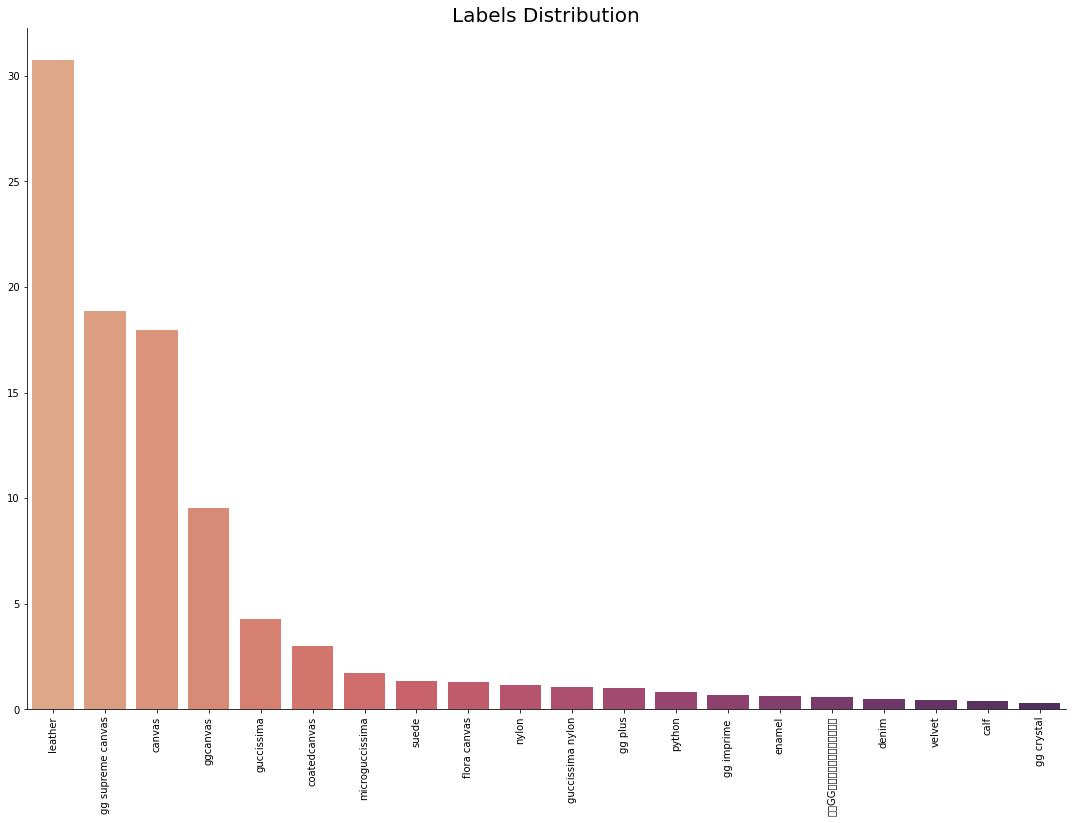

In [104]:
# Histogram with robust frequency labels
top_class_freq = top_class_freq.transpose()   # transpose for visualization

plt.figure(figsize=(16, 14))
sns.catplot(data=top_class_freq, kind="bar", height=10, aspect=1.5, legend_out=True, palette="flare")
plt.xticks(rotation=90)
plt.title('Labels Distribution', fontsize=20)  
# plt.savefig('LabelDist.png')
plt.show()

# 2. Plot a confusion matrix for materials.

## Confusion matrix:

Confusion matrix without Normalized

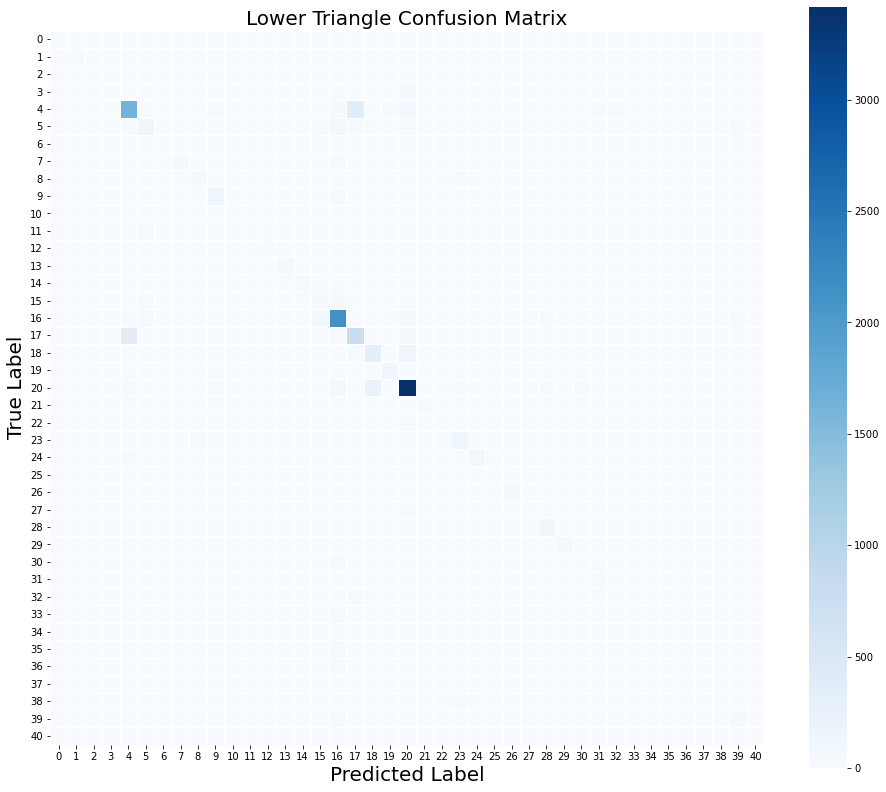

In [92]:
tril_confusion_matrix(y_true, y_pred, tril=False)

Confusion Matrix with Normalized

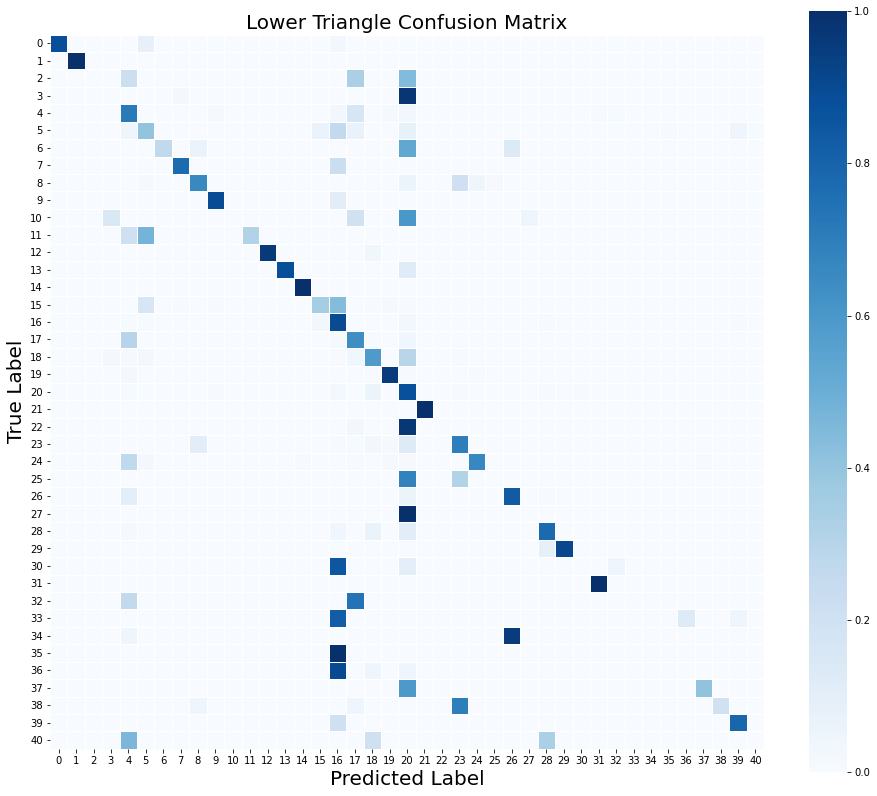

In [74]:
tril_confusion_matrix(y_true, y_pred, normalize="true", tril=False)

In [94]:
a = [4, 16, 17, 20]
for num in a:
    print(label_names[num])

canvas
gg supreme canvas
ggcanvas
leather


In [126]:
confusion_dict = {
    "high_1": [3, 20],
    "high_2": [27, 20],
    "high_3": [22, 20],
    "high_4": [35, 16],
    "high_5": [34, 26],
}

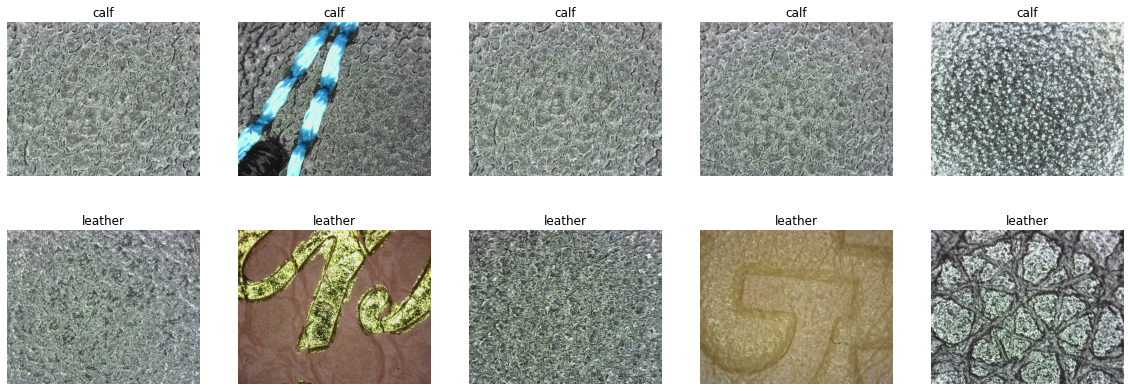

In [156]:
class_sample_comparision(val_df, classify, labels, confusion_dict["high_1"])

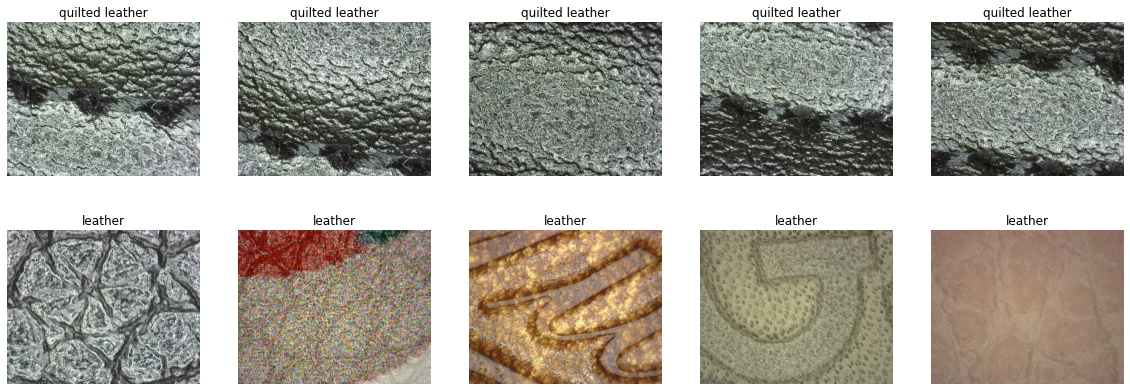

In [157]:
class_sample_comparision(val_df, classify, labels, confusion_dict["high_2"])

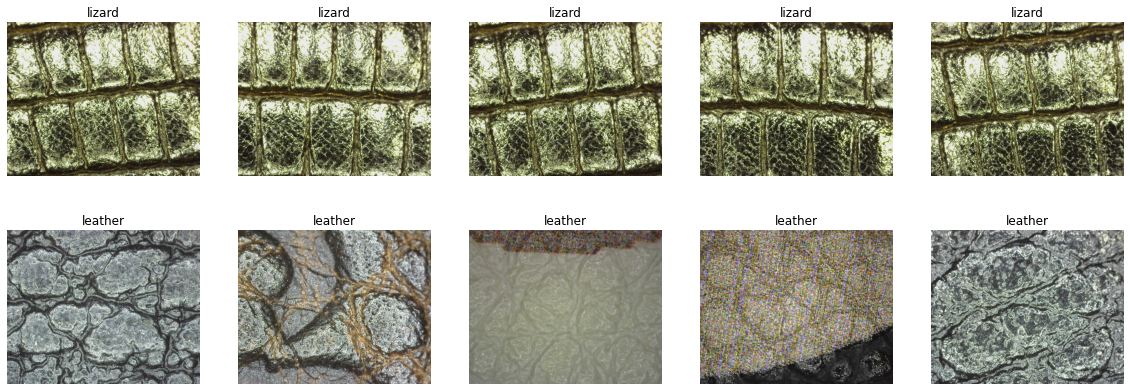

In [158]:
class_sample_comparision(val_df, classify, labels, confusion_dict["high_3"])

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65416 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65400 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_

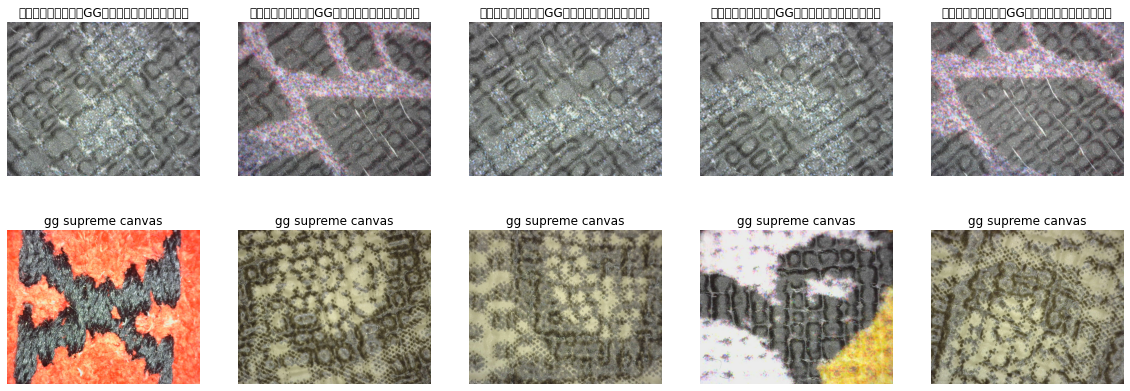

In [159]:
class_sample_comparision(val_df, classify, labels, confusion_dict["high_4"])

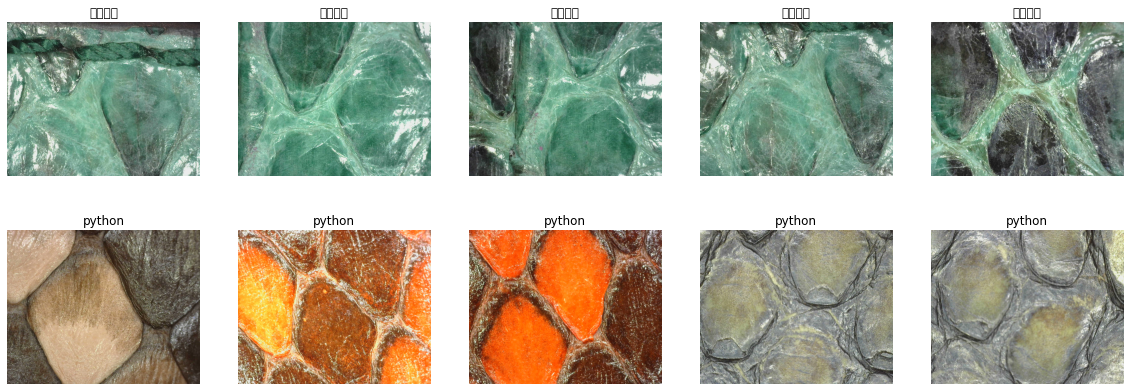

In [160]:
class_sample_comparision(val_df, classify, labels, confusion_dict["high_5"])

# 3. Take a look at results again

## Visualize the worst errors

The prediction label is: leather
The true label is: GGﾅｲﾛﾝ(ECONYL)
The probability is 100.0%


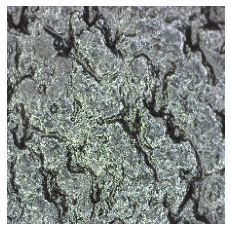

In [78]:
find_the_worst_error(prob=prob, 
                     y_pred=y_pred, 
                     y_true=y_true, 
                     label_names=label_names, 
                     data_ds=val_ds, 
                     batch_size=batch_size)